## Investigating Sentinel SAR data and snowdepth at Grand Mesa, Colorado
*Term Project for CUAHSI Microwave Radar Remote Sensing: Theory and Applications (GEOPH597) CUAHSI Virtual University*

**Victoria Ly** and **Steven Pestana** (University of Washington)
***
#### Data: 
- In situ snow depth measurements from three stations at Grand Mesa, Colorado
- [Sentinel-1 data from Google Earth Engine](https://developers.google.com/earth-engine/sentinel1)


#### References: 
Lievens, H., Demuzere, M., Marshall, H. P., Reichle, R. H., Brucker, L., Brangers, I., … De Lannoy, G. J. M. (2019). Snow depth variability in the Northern Hemisphere mountains observed from space. Nature Communications, 10(1), 1–12. https://doi.org/10.1038/s41467-019-12566-y

In [2]:
import xarray as xr
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from scipy import interpolate
import cartopy.crs as ccrs
import datetime as dt
import gdal

gdal.UseExceptions()

%matplotlib inline

# Set plot fonts to a larger size
#plt.rcParams.update({'font.size': 12})

import warnings
warnings.filterwarnings('ignore')

***
### Grand Mesa surface observations from three met stations, providing snow depth measurements througout the winter in 2017.

Load Grand Mesa West data

In [3]:
# Grand Mesa West data
filepath = r'met_data\MW-V5t_spestana.csv'
gm_west = pd.read_csv(filepath)

# Make some data type and unit conversions
hrs = -6
gm_west['datetime'] = pd.to_datetime(gm_west['TIMESTAMP (TS, )']) # timestamp string to pandas datetime
gm_west['datetime'] +=  pd.to_timedelta(hrs, unit='h')
gm_west = gm_west.sort_values('datetime').reset_index()

# Resample to daily median values. 
#(I chose median so that it's not as influenced by erroneous values as a daily mean would be.)
# Make a copy of the pandas data frame
gm_west_daily_median = gm_west
# Set the datetime column to this new data frame's index
gm_west_daily_median = gm_west_daily_median.set_index('datetime')
# Resample to daily median values based on the datetime index
gm_west_daily_median = gm_west_daily_median.resample('1D').median()

Load Grand Mesa Middle data

In [4]:
# Grand Mesa West data
filepath = r'met_data\MM-V3t_spestana.csv'
gm_middle = pd.read_csv(filepath)

# Make some data type and unit conversions
hrs = -6
gm_middle['datetime'] = pd.to_datetime(gm_middle['TIMESTAMP(TS, )']) # timestamp string to pandas datetime
gm_middle['datetime'] +=  pd.to_timedelta(hrs, unit='h')
gm_middle = gm_middle.sort_values('datetime').reset_index()

# Resample to daily median values. 
#(I chose median so that it's not as influenced by erroneous values as a daily mean would be.)
# Make a copy of the pandas data frame
gm_middle_daily_median = gm_middle
# Set the datetime column to this new data frame's index
gm_middle_daily_median = gm_middle_daily_median.set_index('datetime')
# Resample to daily median values based on the datetime index
gm_middle_daily_median = gm_middle_daily_median.resample('1D').median()

Load Grand Mesa (LSOS) data

In [5]:
# Grand Mesa East data
filepath = r'met_data\LSOS-V2t_spestana.csv'
gm_lsos = pd.read_csv(filepath)

# Make some data type and unit conversions
hrs = -6
gm_lsos['datetime'] = pd.to_datetime(gm_lsos['TIMESTAMP']) # timestamp string to pandas datetime
gm_lsos['datetime'] +=  pd.to_timedelta(hrs, unit='h')
gm_lsos = gm_lsos.sort_values('datetime').reset_index()

# Resample to daily median values. 
#(I chose median so that it's not as influenced by erroneous values as a daily mean would be.)
# Make a copy of the pandas data frame
gm_lsos_daily_median = gm_lsos
# Set the datetime column to this new data frame's index
gm_lsos_daily_median = gm_lsos_daily_median.set_index('datetime')
# Resample to daily median values based on the datetime index
gm_lsos_daily_median = gm_lsos_daily_median.resample('1D').median()

Plot daily median snow depths at all three sites:

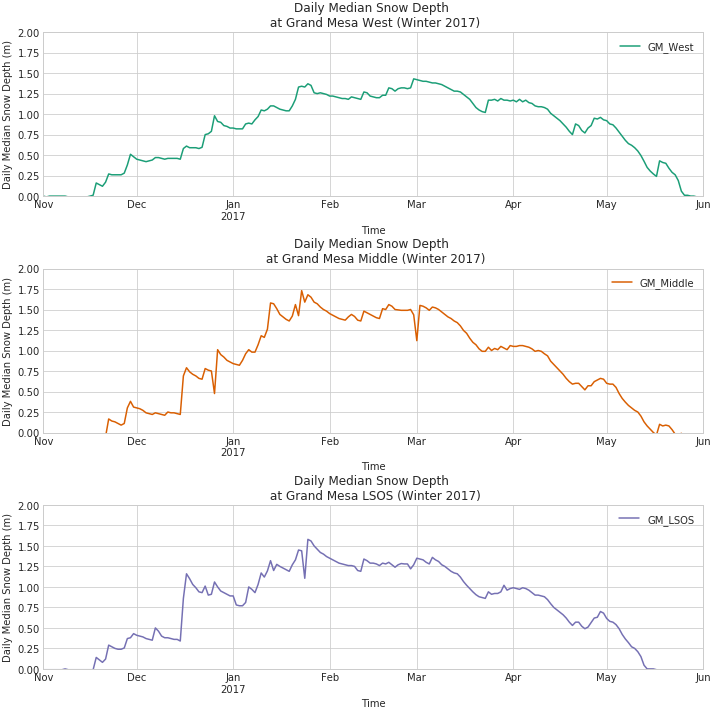

In [6]:
# Set start and end dates to look at here:
starttime = pd.to_datetime('2016-11-01 00:00')
endtime = pd.to_datetime('2017-06-01 23:59:59')

# Plot daily median snow depths:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(3,1,figsize=(10,10))

    ax[0].set_title('Daily Median Snow Depth \n at Grand Mesa West (Winter 2017)');
    gm_west_daily_median.plot(y='Snow Depth (m, Avg)', 
                              c='#1b9e77', ax=ax[0], 
                              label='GM_West')

    ax[1].set_title('Daily Median Snow Depth \n at Grand Mesa Middle (Winter 2017)');
    gm_middle_daily_median.plot(y='Snow Depth(m, Avg)', 
                                c='#d95f02', ax=ax[1], 
                                label='GM_Middle')

    ax[2].set_title('Daily Median Snow Depth \n at Grand Mesa LSOS (Winter 2017)');
    gm_lsos_daily_median.plot(y='Snow Depth (m, Avg)', 
                              c='#7570b3', ax=ax[2], 
                              label='GM_LSOS')
    # format each subplot:
    for n in range(len(ax)):
        ax[n].set_ylim((0,2))
        ax[n].set_xlim((starttime,endtime))
        ax[n].set_ylabel('Daily Median Snow Depth (m)')
        ax[n].set_xlabel('Time')

    plt.tight_layout()
    plt.savefig('daily_median_snowdepth.png',dpi=300)

***
### Grand Mesa Sentinel-1 C-band radar observations.
Load data that was extracted using a [Google Earth Engine script](https://code.earthengine.google.com/4e7a5ba1fd7fcf0d87d9afaeb02c578a).

In [26]:
# Sentinel-1 observations of the Grand Mesa West site
gm_west_sentinel1 = pd.read_csv(r'sentinel1_data/gm_west_sentinel1.csv')
gm_west_sentinel1['system:time_start'] = pd.to_datetime(gm_west_sentinel1['system:time_start'])

# Sentinel-1 observations of the Grand Mesa Middle site
gm_middle_sentinel1 = pd.read_csv(r'sentinel1_data/gm_middle_sentinel1.csv')
gm_middle_sentinel1['system:time_start'] = pd.to_datetime(gm_middle_sentinel1['system:time_start'])

# Sentinel-1 observations of the Grand Mesa LSOS site
gm_lsos_sentinel1 = pd.read_csv(r'sentinel1_data/gm_lsos_sentinel1.csv')
gm_lsos_sentinel1['system:time_start'] = pd.to_datetime(gm_lsos_sentinel1['system:time_start'])

# Sentinel-1 observations of the Grand Mesa open site
gm_open_sentinel1 = pd.read_csv(r'sentinel1_data/gm_open_sentinel1.csv')
gm_open_sentinel1['system:time_start'] = pd.to_datetime(gm_open_sentinel1['system:time_start'])

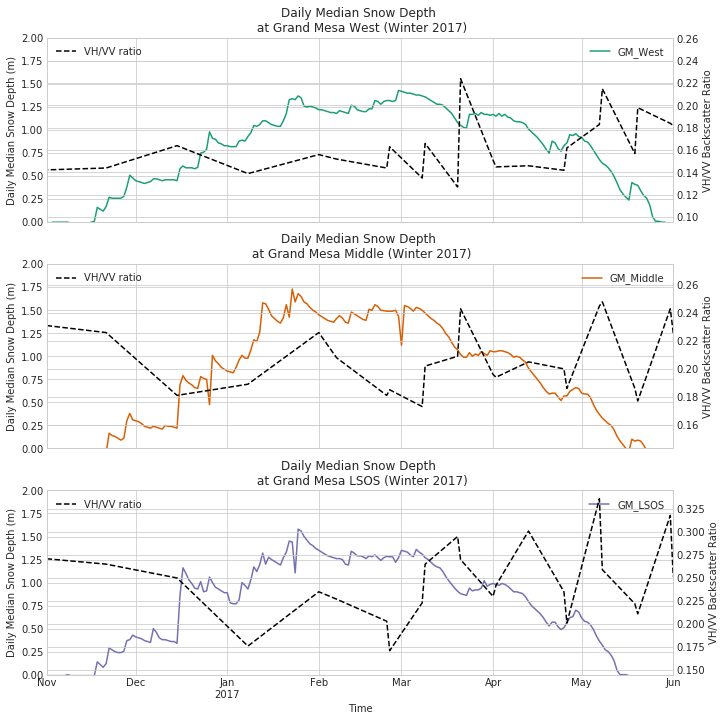

In [42]:
# Set start and end dates to look at here:
starttime = pd.to_datetime('2016-11-01 00:00')
endtime = pd.to_datetime('2017-06-01 23:59:59')

# Plot daily median snow depths:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(3,1,figsize=(10,10))

    ax[0].set_title('Daily Median Snow Depth \n at Grand Mesa West (Winter 2017)');
    gm_west_daily_median.plot(y='Snow Depth (m, Avg)', 
                              c='#1b9e77', ax=ax[0], 
                              label='GM_West')
    ax2 = ax[0].twinx() # add a second y axis for the VH/VV data
    gm_west_sentinel1.plot(x='system:time_start',y='VH_VV_ratio',
                          c='k',linestyle='--', ax=ax2,
                          label='VH/VV ratio')
    ax2.set_ylabel('VH/VV Backscatter Ratio')
    ax2.legend(loc='upper left')
    ax2.set_ylim((0,0.4))

    ax[1].set_title('Daily Median Snow Depth \n at Grand Mesa Middle (Winter 2017)');
    gm_middle_daily_median.plot(y='Snow Depth(m, Avg)', 
                                c='#d95f02', ax=ax[1], 
                                label='GM_Middle')
    ax2 = ax[1].twinx() # add a second y axis for the VH/VV data
    gm_middle_sentinel1.plot(x='system:time_start',y='VH_VV_ratio',
                          c='k',linestyle='--', ax=ax2,
                          label='VH/VV ratio')
    ax2.set_ylabel('VH/VV Backscatter Ratio')
    ax2.legend(loc='upper left')
    ax2.set_ylim((0,0.4))

    ax[2].set_title('Daily Median Snow Depth \n at Grand Mesa LSOS (Winter 2017)');
    l1 = gm_lsos_daily_median.plot(y='Snow Depth (m, Avg)', 
                              c='#7570b3', ax=ax[2], 
                              label='GM_LSOS')
    ax2 = ax[2].twinx() # add a second y axis for the VH/VV data
    l2 = gm_lsos_sentinel1.plot(x='system:time_start',y='VH_VV_ratio',
                          c='k',linestyle='--', ax=ax2,
                          label='VH/VV ratio')
    ax2.set_ylabel('VH/VV Backscatter Ratio')
    ax2.legend(loc='upper left')
    ax2.set_ylim((0,0.4))
    
    # format each subplot:
    for n in range(len(ax)):
        ax[n].set_ylim((0,2))
        ax[n].set_xlim((starttime,endtime))
        ax[n].set_ylabel('Daily Median Snow Depth (m)')
        ax[n].set_xlabel('Time')
        ax[n].legend(loc='upper right')
        

    plt.tight_layout()
    plt.savefig('daily_median_snowdepth-and-sentinel.png',dpi=300)

***
#### Plot snow depth versus the VH/VV ratio.
According to Lievens et al. (2019), the VH/VV ratio is better correlated with snow depth (a positive relationship?)

First, find the corresponding snowdepth for each Sentinel-1 observation:

In [68]:
def nearest(items, pivot):
    #https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

In [81]:
# Grand Mesa West
times = (gm_west_sentinel1['system:time_start'] > starttime) & (gm_west_sentinel1['system:time_start'] < endtime)
snowdepths_west = []
for t in gm_west_sentinel1['system:time_start'][times]:
    insitu_time = nearest(gm_west.datetime,t)
    depth = gm_west['Snow Depth (m, Avg)'][gm_west.datetime == insitu_time].values[0]
    snowdepths_west.append(depth)
snowdepths_west = np.array(snowdepths_west)

In [82]:
# Grand Mesa Middle
times = (gm_middle_sentinel1['system:time_start'] > starttime) & (gm_middle_sentinel1['system:time_start'] < endtime)
snowdepths_middle = []
for t in gm_middle_sentinel1['system:time_start'][times]:
    insitu_time = nearest(gm_middle.datetime,t)
    depth = gm_middle['Snow Depth(m, Avg)'][gm_middle.datetime == insitu_time].values[0]
    snowdepths_middle.append(depth)
snowdepths_middle = np.array(snowdepths_middle)

In [83]:
# Grand Mesa LSOS
times = (gm_lsos_sentinel1['system:time_start'] > starttime) & (gm_lsos_sentinel1['system:time_start'] < endtime)
snowdepths_lsos = []
for t in gm_lsos_sentinel1['system:time_start'][times]:
    insitu_time = nearest(gm_lsos.datetime,t)
    depth = gm_lsos['Snow Depth (m, Avg)'][gm_lsos.datetime == insitu_time].values[0]
    snowdepths_lsos.append(depth)
snowdepths_lsos = np.array(snowdepths_lsos)

Filter out snowdepths less than some threshold:

In [92]:
min_snowdepth = 0.1

# Grand Mesa West
vh_vv_ratio_west = gm_west_sentinel1['VH_VV_ratio'][times][snowdepths_west>min_snowdepth]
snowdepth_west = snowdepths_west[snowdepths_west>min_snowdepth]

# Grand Mesa Middle
vh_vv_ratio_middle = gm_middle_sentinel1['VH_VV_ratio'][times][snowdepths_middle>min_snowdepth]
snowdepth_middle = snowdepths_middle[snowdepths_middle>min_snowdepth]

# Grand Mesa LSOS
vh_vv_ratio_lsos = gm_lsos_sentinel1['VH_VV_ratio'][times][snowdepths_lsos>min_snowdepth]
snowdepth_lsos = snowdepths_lsos[snowdepths_lsos>min_snowdepth]

Snowdepth versus VH/VV ratio plots:

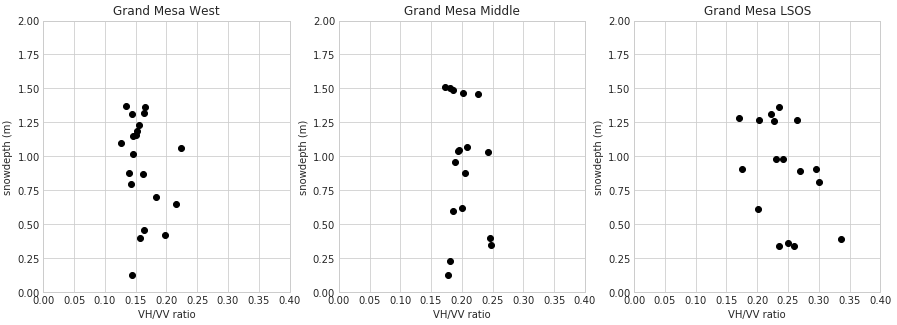

In [94]:
with plt.style.context('seaborn-whitegrid'):
    f, ax = plt.subplots(1,3,figsize=(15,5))
                         
    # GM West
    ax[0].plot(vh_vv_ratio_west,snowdepth_west, 'ok')
    ax[0].set_title('Grand Mesa West')
                         
    # GM Middle
    ax[1].plot(vh_vv_ratio_middle,snowdepth_middle, 'ok')
    ax[1].set_title('Grand Mesa Middle')
        
    # GM LSOS
    ax[2].plot(vh_vv_ratio_lsos,snowdepth_lsos, 'ok')
    ax[2].set_title('Grand Mesa LSOS')
    
                         
    for n in range(len(ax)):
        ax[n].set_ylabel('snowdepth (m)')
        ax[n].set_ylim((0,2))
        ax[n].set_xlabel('VH/VV ratio')
        ax[n].set_xlim((0,0.4))
    
    plt.savefig('snowdepth-versus-vh_vv_ratio.png',dpi=300)

Wait, that doesn't look like what I'd expect if snowdepth and VH/VV were correlated...